In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mstats #信頼区間（統計的概念）をimportする
import pystan
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df=pd.read_excel("./data/multilevel_modeling.xlsx")

In [4]:
df.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


In [6]:
df["id"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

In [7]:
len(df["id"].unique())

15

In [9]:
groups=df.groupby(df["id"])#idによってグループ分け(このグループの集合をgroupsという)、idによってグループ分けするのでグループ名(name)はそれぞれid,そのグループに含まれるデータをgroupという

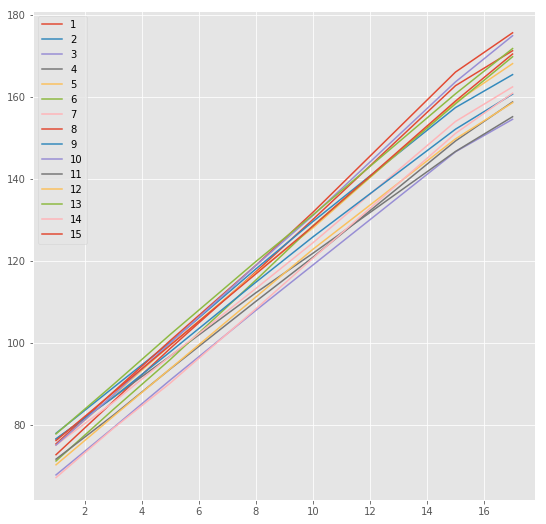

In [11]:
plt.figure(figsize=(9,9))
for name,group in groups:
    plt.plot(group["age"],group["height"],label=name)
plt.legend()

In [26]:
stan_model="""
data{
  int N;
  int N_id;
  real X[N];
  real Y[N];
  int<lower=1,upper=N_id> s_id[N];
}

parameters {
  real a0;
  real b0;
  real a_id[N_id];
  real b_id[N_id];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters{
  real a[N_id];
  real b[N_id];
  for (n in 1:N_id){
    a[n]=a0+a_id[n];
    b[n]=b0+b_id[n];
  }
}

model{
  for (id in 1:N_id){
    a_id[id]~normal(0,s_a);
    b_id[id]~normal(0,s_b);
  }
  
  for (n in 1:N){
    Y[n]~normal(a[s_id[n]]*X[n]+b[s_id[n]],s_Y);
  }
}
"""

In [ ]:
#transformed parametersはparametersを用いて新たにパラメータを作り出すための部分

In [21]:
sm=pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7904c331e5597d71ed4a2fc92f637ed4 NOW.


In [25]:
stan_data={"N":df.shape[0],"N_id":15,"X":df["age"],"Y":df["height"],"s_id":df["id"]}

In [27]:
fit=sm.sampling(data=stan_data,iter=2000,warmup=500,chains=3,seed=123)

In [28]:
fit

Inference for Stan model: anon_model_7904c331e5597d71ed4a2fc92f637ed4.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0         5.77  5.3e-3   0.11   5.53    5.7   5.77   5.84   5.99    468   1.01
b0        68.22    0.04   0.92   66.5  67.64  68.19  68.78  70.17    637   1.01
a_id[1]    0.47  5.3e-3   0.13   0.21   0.38   0.46   0.55   0.73    571   1.01
a_id[2]   -0.19  5.3e-3   0.13  -0.44  -0.27  -0.19  -0.11   0.08    593   1.01
a_id[3]   -0.29  5.3e-3   0.13  -0.54  -0.37  -0.29  -0.21  -0.03    572   1.01
a_id[4]    -0.8  5.3e-3   0.13  -1.05  -0.88   -0.8  -0.72  -0.54    579   1.01
a_id[5]    0.09  5.3e-3   0.13  -0.16 3.6e-3   0.08   0.17   0.36    576   1.01
a_id[6]    0.41  5.3e-3   0.13   0.16   0.32    0.4   0.49   0.67    593   1.01
a_id[7]   -0.21  5.4e-3   0.13  -0.46  -0.29  -0.21  -0.13   0.05    540   1.01
a_id[8]    0

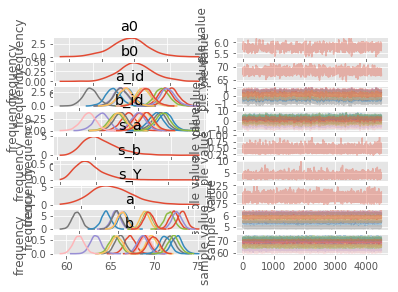

In [30]:
fig=fit.plot()

In [31]:
ms_a=fit.extract("a")["a"]
ms_b=fit.extract("b")["b"]

In [33]:
x=np.arange(18)
df_b=pd.DataFrame([])
for i in range(18):
    df_b[i]=ms_a[:,0]*x[i]+ms_b[:,0]

In [34]:
low_y50,high_y50=mstats.mquantiles(df_b,[0.25,0.75],axis=0)
low_y95,high_y95=mstats.mquantiles(df_b,[0.025,0.975],axis=0)

In [35]:
df_0=groups.get_group(1)

In [36]:
df_0.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


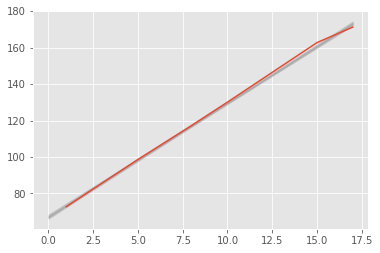

In [38]:
plt.plot(df_0["age"],df_0["height"])
plt.fill_between(x,low_y50,high_y50,alpha=0.6,color="darkgray")
plt.fill_between(x,low_y95,high_y95,alpha=0.3,color="gray")